In [2]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import io

df = pd.read_csv('/content/drive/My Drive/ML SDP Project Items/SpamTextCSV.csv') # Assuming the file is in your MyDrive
print(df.head())

Mounted at /content/drive
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


Undersampling

In [3]:
import numpy as np
#compute the length of majority & minority class
minority_len=len(df[df["Category"]=="spam"])
majority_len=len(df[df["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=df[df["Category"]=="spam"].index
majority_indices=df[df["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)
#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

# print(undersampled_indices)
#create df using new indices
data=df.loc[undersampled_indices]

#shuffle the sample
data=data.sample(frac=1)

#reset the index as its all mixed
data=data.reset_index()

#drop the older index
data=data.drop(
    columns=["index"],
)

In [4]:
data["Label"]=data["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [5]:
data.shape
data["Category"].value_counts()

,count
Category,
spam,924
ham,924


In [6]:
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()
#declare empty list to store tokenized message
corpus=[]

#iterate through the data["Message"]
for message in data["Message"]:

    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)

    #convert every letters to its lowercase
    message=message.lower()

    #split the word into individual word list
    message=message.split()

    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    #join the word lists with the whitespace
    message=" ".join(message)

    #append the message in corpus list
    corpus.append(message)

In [8]:
corpus[0]

'want funk ur fone weekli new tone repli tone u text www rington co uk origin n best tone gbp network oper rate appli'

In [9]:
newdf = pd.DataFrame({"Message":corpus,"Label":data["Label"]})

In [10]:
newdf.head()

,Message,Label
0,want funk ur fone weekli new tone repli tone u...,1
1,wonder time spend day famili,0
2,antha num corrct dane,0
3,yup anyth lor u dun wan ok,0
4,hear,0


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(corpus, newdf['Label'], test_size=0.15, random_state=42)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [13]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_vec, y_train)

SVC(kernel='linear')

In [14]:
from sklearn.metrics import accuracy_score

y_pred = svm_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9640287769784173


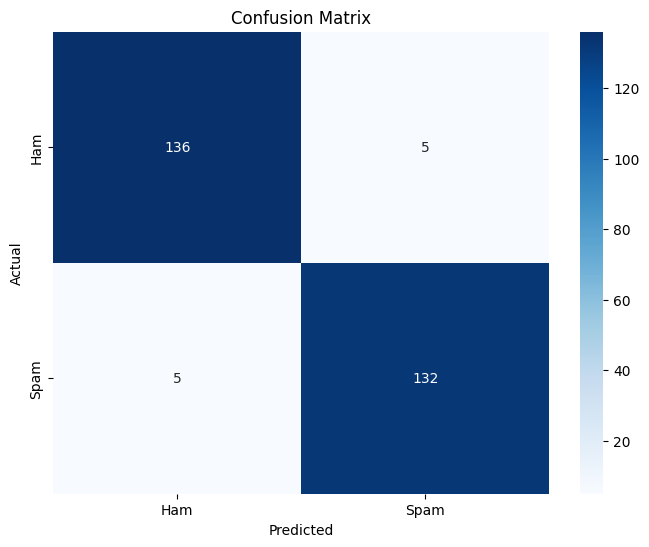

In [15]:
# prompt: give confusion matrix for above

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your previous code

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# prompt: construct a function that takes the model and sentence and prints whether sentence is spam or not spam

def predict_spam(model, sentence):
    # Preprocess the input sentence
    stemmer = PorterStemmer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = sentence.lower()
    sentence = sentence.split()
    sentence = [stemmer.stem(word) for word in sentence if word not in set(stopwords.words("english"))]
    sentence = " ".join(sentence)

    # Vectorize the sentence
    vectorized_sentence = vectorizer.transform([sentence])

    # Make the prediction
    prediction = model.predict(vectorized_sentence)[0]

    # Print the result
    if prediction == 1:
        print("Spam")
    else:
        print("Not Spam")

In [17]:
# prompt: call predict_spam by giving it a spam text

predict_spam(svm_model, "Going for shopping to buy dress")
predict_spam(svm_model, "You won 200$!! Woahh!! email us your account number and you will get your prize money!!")
predict_spam(svm_model, "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv")
predict_spam(svm_model, "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030")

Not Spam
Spam
Spam
Spam
